# CMS Open Data $t\bar{t}$-analysis using RDF
This notebook was developed to showcase [RDF](https://root.cern/doc/master/classROOT_1_1RDataFrame.html)
applying to [2015 CMS Open Data](https://cms.cern/news/first-cms-open-data-lhc-run-2-released) $t\bar{t}$-analysis.\
This is a technical implementation of the analysis procedure described [here](https://github.com/andriiknu/RDF/blob/master/doc.ipynb).\
There is [another implementation](https://github.com/iris-hep/analysis-grand-challenge/blob/main/analyses/cms-open-data-ttbar/coffea.ipynb) producing the same results using [Coffea analysis framework]((https://github.com/iris-hep/analysis-grand-challenge/blob/main/analyses/cms-open-data-ttbar/coffea.ipynb)

### Setting up environment: imports

In [1]:
import json
import ROOT
from ROOT import RDataFrame, TCanvas, THStack
ROOT.EnableImplicitMT()
import numpy as np
%jsroot on
print(f'The num of threads = {ROOT.GetThreadPoolSize()}')
# ROOT.TH1.SetDefaultSumw2(true)
# verbosity = ROOT.Experimental.RLogScopedVerbosity(ROOT.Detail.RDF.RDFLogChannel(), ROOT.Experimental.ELogLevel.kInfo)

Welcome to JupyROOT 6.26/04
The num of threads = 10


### Setting up environment: ***helper.cpp*** compilation

In [2]:
ROOT.gSystem.CompileMacro("helper.cpp", "kO")

1

`helper.cpp` is a file containing helpful c++ functions to perform analysis.\
A couple of them gives scaling factors applied for variations construction:
* *`pt_scale_up`*: jet transverse momentum values scaling by a constant factor
* *`pt_res_up`*: jet transverse momentum values scaling according to normal distribution
* *`btag_weight_variation`*: weights variations
* *`flat_variation`*: weights flat variations some of the processes

Other of them are written for ROOT histogram slicing.

### Global configurations
 `N_FILES_MAX_PER_SAMPLE`  is a variable determining the number of input files per sample, i. e. the dataset size to be processed.\
9 samples are being used here, all part of the 2015 CMS Open Data release. 
More details about the inputs can be found [here](https://github.com/iris-hep/analysis-grand-challenge/tree/main/datasets/cms-open-data-2015) or in the [Coffea implementation](https://github.com/iris-hep/analysis-grand-challenge/blob/main/analyses/cms-open-data-ttbar/coffea.ipynb) mentioned at the beginning.

`LOCAL` specify whether input files are locally placed. To use it, you must save input files locally by setting `DOWNLOAD` to `True`. This option will create an `input` directory to save input files. Otherwise, turn off the `LOCAL` and `DOWNLOAD` options by setting `False` to both. If `LOCAL` equals `False`, remote inputs will be accessed through HTTPS. 

`FILE` is the name of the output file.

In [3]:
N_FILES_MAX_PER_SAMPLE = 50
DOWNLOAD = False
LOCAL = True
FILE = f'histograms/rdf-{N_FILES_MAX_PER_SAMPLE}.root'

### TtbarAnalysis class definition
Encapsulates full analysis pipeline and provides helpful methods for data delivery and processing, and histogram construction. Serves as analysis manager.

In [4]:
from urllib.request import urlretrieve
import os


class TtbarAnalysis(dict):

    def __init__(self, n_files_max_per_sample = 1, num_bins=25, bin_low = 50, bin_high = 550, download_input_data=False, use_local_data=False):
        
        
        self.variations = {} # serves as temporary storage for all histograms produced by VariationsFor
        self.download_input_data = download_input_data  # set True to download input files
        self.use_local_data = use_local_data            # set True to use locally placed input files instead of https accessing
        self._nevts_total = {}
        self.n_files_max_per_sample = n_files_max_per_sample  #the number of files to be processed per sample
        self.input_data = self._construct_fileset() # dictionary assigning file URLs (paths) to each process, variation, and region
        self.num_bins = num_bins
        self.bin_low = bin_low
        self.bin_high = bin_high
        # using https://atlas-groupdata.web.cern.ch/atlas-groupdata/dev/AnalysisTop/TopDataPreparation/XSection-MC15-13TeV.data
        # for reference
        # x-secs are in pb
        self.xsec_info = {
            "ttbar": 396.87 + 332.97, # nonallhad + allhad, keep same x-sec for all
            "single_top_s_chan": 2.0268 + 1.2676,
            "single_top_t_chan": (36.993 + 22.175)/0.252,  # scale from lepton filter to inclusive
            "single_top_tW": 37.936 + 37.906,
            "wjets": 61457 * 0.252,  # e/mu+nu final states
            "data": None
        }
        ROOT.gInterpreter.Declare(f"auto pt_res_up_obj = pt_res_up({ROOT.GetThreadPoolSize()});")
        

    def _construct_fileset(self):
        n_files_max_per_sample = self.n_files_max_per_sample
        with open ('ntuples.json') as f:
            file_info = json.load(f)
        fileset = {}
        for process in file_info.keys():
            if process == "data":
                continue  # skip data
            fileset[process] = {}
            self[process] = {}
            self._nevts_total[process] = {}
            for variation in file_info[process].keys():
#                 if variation != 'nominal': continue      
                file_list = file_info[process][variation]["files"]
                if n_files_max_per_sample != -1:
                    file_list = file_list[:n_files_max_per_sample]  # use partial set of samples
                file_paths = [f["path"] for f in file_list]
                nevts_total = sum([f["nevts"] for f in file_list])
                self._nevts_total[process].update({variation:nevts_total})
                fileset[process].update({variation: file_paths})
                #download input files if turned
                if (self.download_input_data):
                    dir_name = f"input/{process}_{variation}"
                    os.makedirs(dir_name, exist_ok=True)
                    for i in range(len(file_paths)):
                        path = file_paths[i]
                        file = f"{dir_name}/{i}.root"
                        if not os.path.exists(file):
                            urlretrieve(path, file)   
                            print(f"{file} has been created")
                        else:
                            print(f"{file} already exists")
                self[process][variation] = {}
                
        return fileset

    def fill(self, process, variation, ):
        
        # analysis algorithm themself implemented here
        # fill function accepts parameters pair (process, variation) to which are assigned files in self.input_data
        
        # all operations are handled by RDataFrame class, so the first step is the RDataFrame object instantiating
        input_data = [f"root://eosuser.cern.ch//eos/user/a/afalko/analysis-grand-challenge/analyses/cms-open-data-ttbar/input/{process}_{variation}/{i}.root" for i in range(self.n_files_max_per_sample)] if self.use_local_data else self.input_data[process][variation]               
        d = RDataFrame('events', input_data)
        
        # normalization for MC
        x_sec = self.xsec_info[process]
        nevts_total = self._nevts_total[process][variation]
        lumi = 3378 # /pb
        xsec_weight = x_sec * lumi / nevts_total
        d = d.Define('weights', str(xsec_weight)) #default weights
        
        
        
        if variation == 'nominal':
            
            # jet_pt variations definition
            # pt_scale_up() and pt_res_up(jet_pt) return scaling factors applying to jet_pt
            # pt_scale_up() - jet energy scaly systematic
            # pt_res_up(jet_pt) - jet resolution systematic 

            
            d = d.Vary('jet_pt', "ROOT::RVec<ROOT::RVecF>{jet_pt*pt_scale_up(), jet_pt*pt_res_up_obj(jet_pt, rdfslot_)}", ["pt_scale_up", "pt_res_up"])
            if process == 'wjets':
                
                # flat weight variation definition
                d = d.Vary('weights', 
                           "weights*flat_variation()",
                           [f"scale_var_{direction}" for direction in ["up", "down"]]
                          )
                
        ### event selection - the core part of the algorithm applied for both regions
        # selecting events containing at least one lepton and four jets with pT > 25 GeV
        # applying requirement at least one of them must be b-tagged jet (see details in the specification)
        d = d.Define('electron_pt_mask', 'electron_pt>25').Define('muon_pt_mask', 'muon_pt>25').Define('jet_pt_mask', 'jet_pt>25')\
             .Filter('Sum(electron_pt_mask) + Sum(muon_pt_mask) == 1')\
             .Filter('Sum(jet_pt_mask) >= 4')\
             .Filter('Sum(jet_btag[jet_pt_mask]>=0.5)>=1')
             
        
        # b-tagging variations for nominal samples
        d = d.Vary('weights', 
                   'ROOT::RVecD{weights*btag_weight_variation(jet_pt[jet_pt_mask])}',
                   [f"{weight_name}_{direction}" for weight_name in [f"btag_var_{i}" for i in range(4)] for direction in ["up", "down"]]
                  ) if variation == 'nominal' else d
        
        

        ## as next steps for different regions are different, there is a fork in the algorithm
        # we create another RDF pointer for each region called "fork"
        measured = {"4j1b": "HT", "4j2b": 'trijet_mass'} # columns names of observables for two regions
        for region in ["4j1b","4j2b"]:
            observable = measured[region]
            
            if region == "4j1b":
                
                # only one b-tagged region required
                # observable is total transvesre momentum 
                fork = d.Filter('Sum(jet_btag[jet_pt_mask]>=0.5)==1').Define(observable, 'Sum(jet_pt[jet_pt_mask])')      

            elif region == "4j2b":
                
                # select events with at least 2 b-tagged jets
                # building four-momentum vectors for each jet
                fork = d.Filter('Sum(jet_btag[jet_pt_mask]>=0.5)>1').Define("jet_p4", 
                    "ROOT::VecOps::Construct<ROOT::Math::PxPyPzMVector>(jet_px[jet_pt_mask], jet_py[jet_pt_mask], jet_pz[jet_pt_mask], jet_mass[jet_pt_mask])"
                )
                
                # building trijet combinations
                fork = fork.Define('trijet', 
                    'ROOT::VecOps::Combinations(jet_pt[jet_pt_mask],3)'
                ).Define('ntrijet', 'trijet[0].size()')

                # assigning four-momentums to each trijet combination
                fork = fork.Define('trijet_p4', 
                                      'ROOT::VecOps::RVec<ROOT::Math::PxPyPzMVector> trijet_p4(ntrijet);'              +\
                                      'for (int i = 0; i < ntrijet; ++i) {'                                            +\
                                          'int j1 = trijet[0][i]; int j2 = trijet[1][i]; int j3 = trijet[2][i];'       +\
                                          'trijet_p4[i] = jet_p4[j1] + jet_p4[j2] + jet_p4[j3];'                       +\
                                      '}'                                                                              +\
                                      'return trijet_p4;'                                                                                                                          
                                     )

                # getting trijet transverse momentum values from four-momentum vectors
                fork = fork.Define('trijet_pt', 
                        'return ROOT::VecOps::Map(trijet_p4, [](ROOT::Math::PxPyPzMVector v) { return v.Pt(); })'
                                            )

              
                # trijet_btag is a helpful array of bool values indicating whether or not the maximum btag value in trijet is larger than 0.5 threshold 
                fork = fork.Define('trijet_btag', 
                                                  'ROOT::VecOps::RVec<bool> btag(ntrijet);'                                   +\
                                                  'for (int i = 0; i < ntrijet; ++i) {'                                       +\
                                                   'int j1 = trijet[0][i]; int j2 = trijet[1][i]; int j3 = trijet[2][i];'     +\
                                                   'btag[i]=std::max({jet_btag[j1], jet_btag[j2], jet_btag[j3]})>0.5;'        +\
                                                  '}'                                                                         +\
                                                  'return btag;'
                                            )
                # find trijet with maximum pt and higher that threshold btag
                # get mass for found jet four-vector 
                # trijet mass themself is an observable quantity
                fork=fork.Define(observable,
                                                  'double mass;'+\
                                                  'double Pt = 0;'+\
                                                  'double indx = 0;'+\
                                                  'for (int i = 0; i < ntrijet; ++i) {'               +\
                                                  '    if ((Pt < trijet_pt[i]) && (trijet_btag[i])) {'+\
                                                  '        Pt = trijet_pt[i];'+\
                                                  '        indx=i;'+\
                                                  '    }'                                            +\
                                                  '}'                                                +\
                                                  'mass = trijet_p4[indx].M();'             +\
                                                  'return mass;'
                                                 )
                
            
            # fill histogram for observable column in RDF object
            res = fork.Histo1D((f'{process}_{variation}_{region}', process, self.num_bins, self.bin_low, self.bin_high), observable, 'weights')
            self.hist.append(res) # save the pointer to further triggering 
            print(f'histogram {region}_{process}_{variation} has been created')
            
            # save pointers for variations
            # self.variations is a temporary container for all pointers
            if variation == 'nominal':
                self.variations[f"{process}__{region}"] = ROOT.RDF.Experimental.VariationsFor(res)
            else:
                self[process][variation][region] = res

    # build 9 Graphs for each data sample            
    def Fill(self):
        self.hist = []
        for process in self:
            
            for variation in self.input_data[process]:
                self.fill(process=process, variation=variation)

    # run 9 Graphs for each data sample            
    def Accumulate(self):
        ROOT.RDF.RunGraphs(self.hist)  
    
    # transform TtbarAnalysis to dictionary (process, variation, region) -> hitogram
    def TransfToDict(self):
        for key in self.variations.keys():
            hist_map = self.variations[key]
            key = str(key).split('__')
            process = key[0]; region = key[1]
            for hist_name in hist_map.GetKeys():
                variation = 'nominal' if hist_name == 'nominal' else str(hist_name).split(':')[1]
                if variation not in self[process]: self[process][variation] = {}
                hist = hist_map[hist_name]
                if not isinstance(hist, ROOT.TH1D): hist = hist.GetValue()
                analysisManager[process][variation][region] = hist
        analysisManager.ExportJSON()
        
    def GetProcStack(self, region, variation='nominal'):
        return [self[process][variation][region] for process in self]
    
    def GetVarStack(self, region, process="ttbar"):
        return [self[process][variation][region] for variation in self[process]]
    
    # necessary only for sanity checks
    def ExportJSON(self):
        data = {}
        for process in self:
            data[process] = {}
            for variation in self[process]:
                data[process][variation] = [region for region in self[process][variation]]
        with open('data.json', 'w') as f:
            json.dump(data, f)
                
                
                    

### Analysis manager configuration
To perform analysis, one needs to instantiate the TtbarAnalysis object. TtbarAnalysis constructor method accepts arguments determining all TtbarAnalysi analysis behavior.
Main settings:
* `n_files_max_per_sample` - the number of files which will be processed per sample (1 by default)
* `use_local_data` - choose locally or remotely placed input files
* `download_input_data` - specify will or not the files be downloaded

In [5]:
analysisManager = TtbarAnalysis(download_input_data=DOWNLOAD, use_local_data=LOCAL, n_files_max_per_sample = N_FILES_MAX_PER_SAMPLE)

At this stage, analysisManager keeps all file URLs:

In [6]:
print(f"processes in fileset: {list(analysisManager.keys())}")
print(f"\nexample of information inside analysisManager:\n{{\n  'urls': [{analysisManager.input_data['ttbar']['nominal'][0]}, ...],")

processes in fileset: ['ttbar', 'single_top_s_chan', 'single_top_t_chan', 'single_top_tW', 'wjets']

example of information inside analysisManager:
{
  'urls': [https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/00DF0A73-17C2-E511-B086-E41D2D08DE30.root, ...],


Note, if you set **`use_local_data`** to the **`True`**, **local paths** will be used instead of printed URLs.

### Build histograms and execute data processing

In [7]:
import time
t0 = time.time()

analysisManager.Fill()
t1 = time.time()
print(f"\npreprocessing took {round(t1 - t0,2)} seconds")
analysisManager.Accumulate()
t2 = time.time()
print(f"processing took {round(t2 - t1,2)} seconds")
print(f"execution took {round(t2 - t0,2)} seconds")

histogram 4j1b_ttbar_nominal has been created
histogram 4j2b_ttbar_nominal has been created
histogram 4j1b_ttbar_scaledown has been created
histogram 4j2b_ttbar_scaledown has been created
histogram 4j1b_ttbar_scaleup has been created
histogram 4j2b_ttbar_scaleup has been created
histogram 4j1b_ttbar_ME_var has been created
histogram 4j2b_ttbar_ME_var has been created
histogram 4j1b_ttbar_PS_var has been created
histogram 4j2b_ttbar_PS_var has been created
histogram 4j1b_single_top_s_chan_nominal has been created
histogram 4j2b_single_top_s_chan_nominal has been created
histogram 4j1b_single_top_t_chan_nominal has been created
histogram 4j2b_single_top_t_chan_nominal has been created
histogram 4j1b_single_top_tW_nominal has been created
histogram 4j2b_single_top_tW_nominal has been created
histogram 4j1b_wjets_nominal has been created
histogram 4j2b_wjets_nominal has been created

preprocessing took 22.08 seconds
processing took 144.26 seconds
execution took 166.34 seconds


In [8]:
analysisManager.TransfToDict()
analysisManager['ttbar'].keys()

dict_keys(['nominal', 'scaledown', 'scaleup', 'ME_var', 'PS_var', 'pt_res_up', 'pt_scale_up', 'btag_var_0_down', 'btag_var_0_up', 'btag_var_1_down', 'btag_var_1_up', 'btag_var_2_down', 'btag_var_2_up', 'btag_var_3_down', 'btag_var_3_up'])

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file histograms/reg1.png has been created


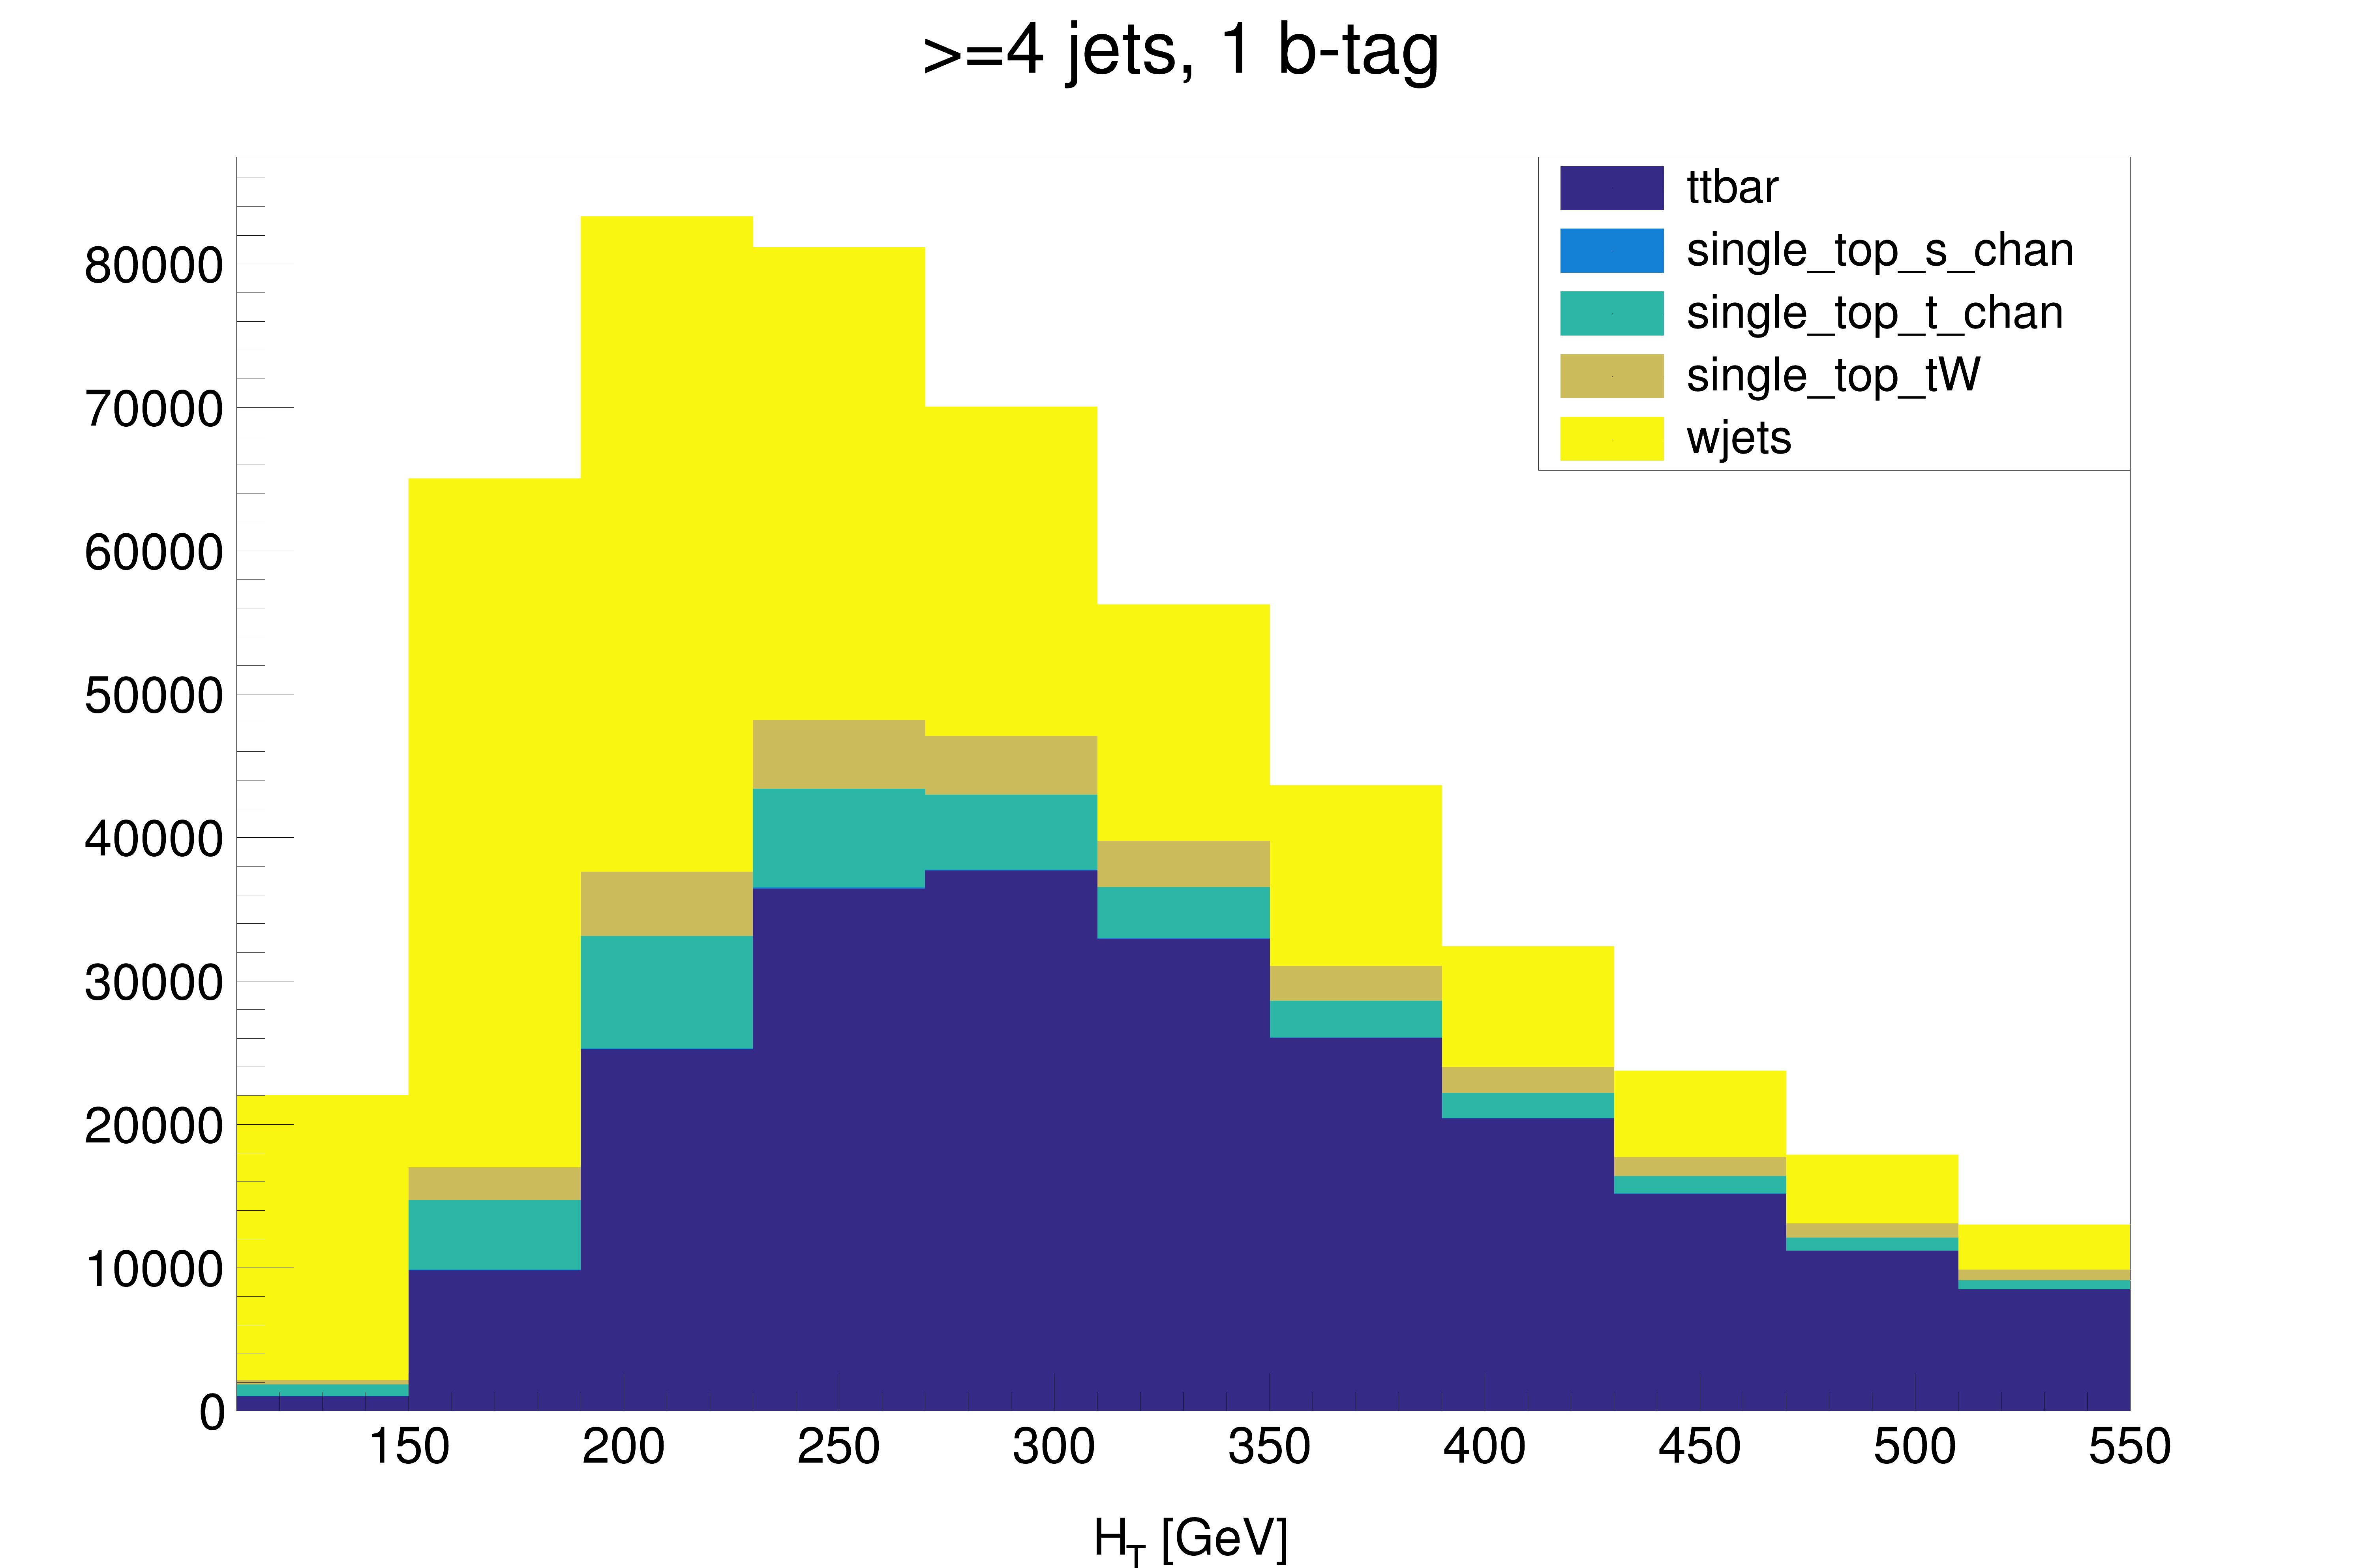

In [49]:
%jsroot off
c = TCanvas('c', 'c', 3000*2, 2000*2) 
hlist = analysisManager.GetProcStack(region='4j1b')
hs = THStack('j4b1', '>=4 jets, 1 b-tag; H_{T} [GeV]')
for h in hlist:
    h = ROOT.Slice(h, 120, 550)
    ptr = h.Rebin(2, h.GetTitle())
    hs.Add(ptr)
hs.Draw('hist pfc plc')
c.Draw()
x = hs.GetXaxis()
x.SetTitleOffset(1.5)
x.CenterTitle()
c.BuildLegend(0.65, 0.7, 0.9, 0.9)
c.SaveAs('histograms/reg1.png')

Info in <TCanvas::Print>: png file histograms/reg2.png has been created


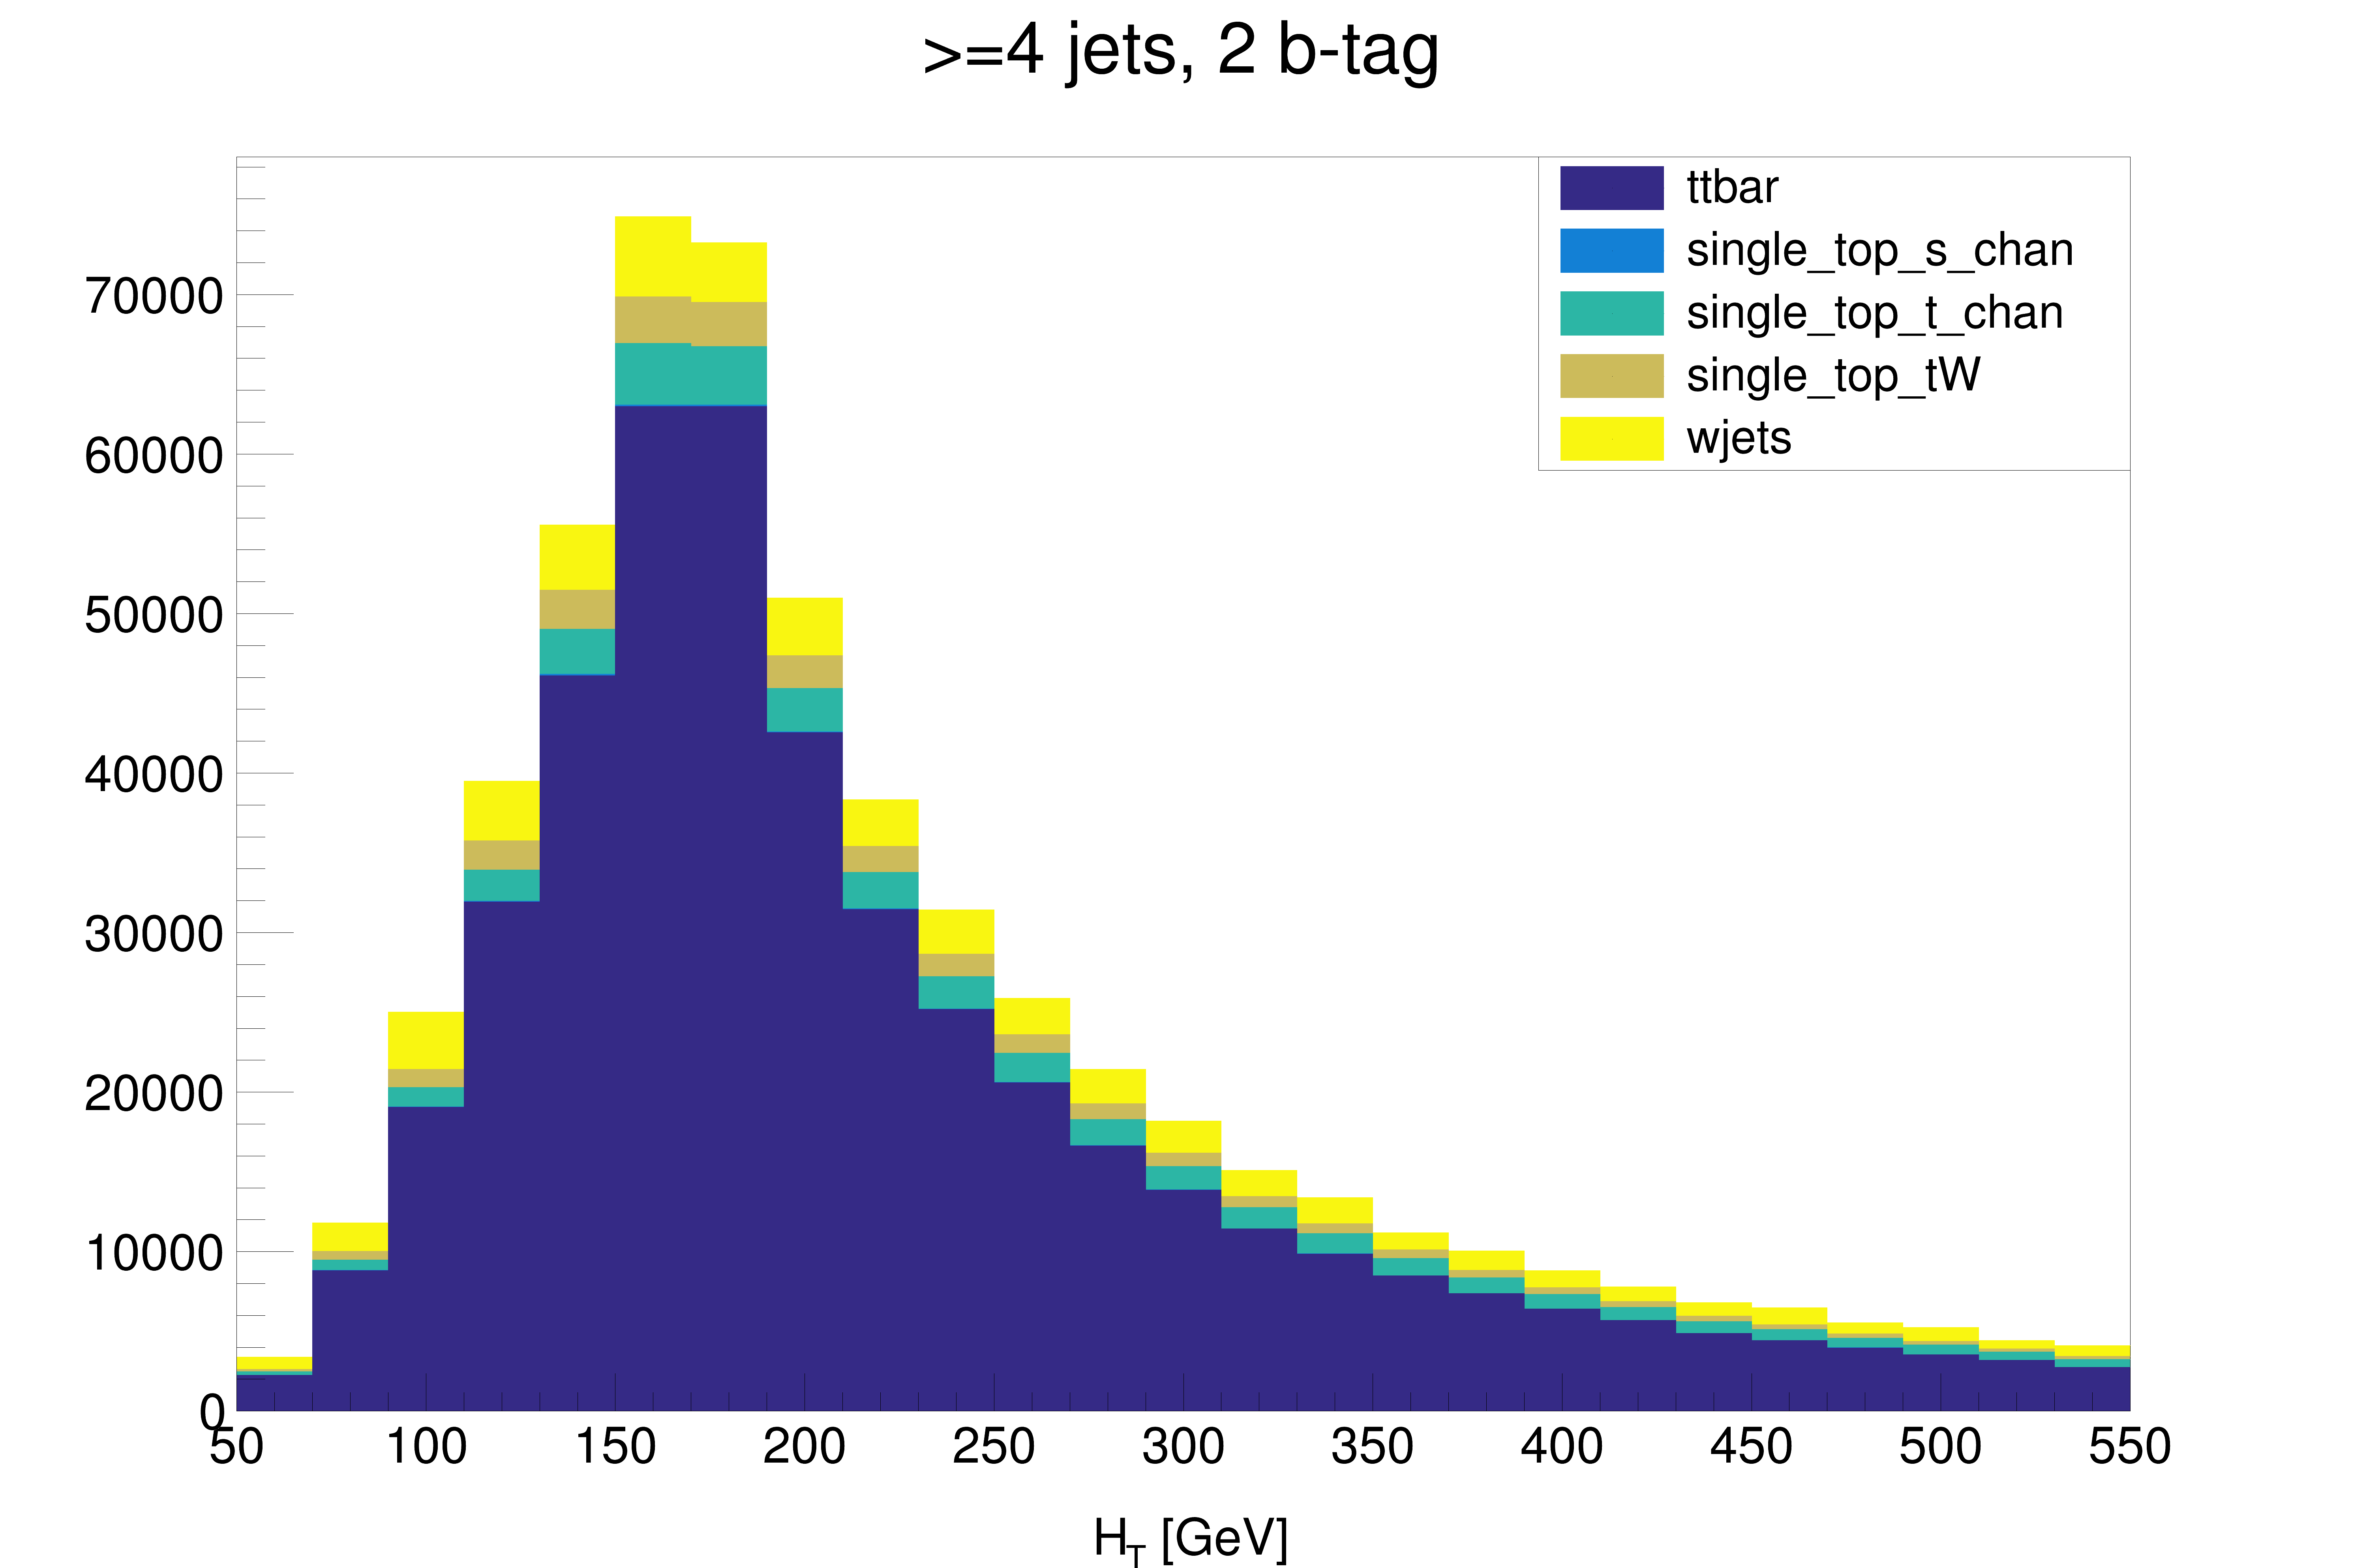

In [50]:
hlist = analysisManager.GetProcStack(region='4j2b')
hs = THStack('j4b1', '>=4 jets, 2 b-tag; H_{T} [GeV]')
for h in hlist:
    hs.Add(h)
hs.Draw('hist pfc plc')
c.Draw()
x = hs.GetXaxis()
x.SetTitleOffset(1.5)
x.CenterTitle()
c.BuildLegend(0.65, 0.7, 0.9, 0.9)
c.SaveAs('histograms/reg2.png')

Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nbins=25.
Warning in <TH1D::Rebin>: ngroup=2 is not an exact divider of nb

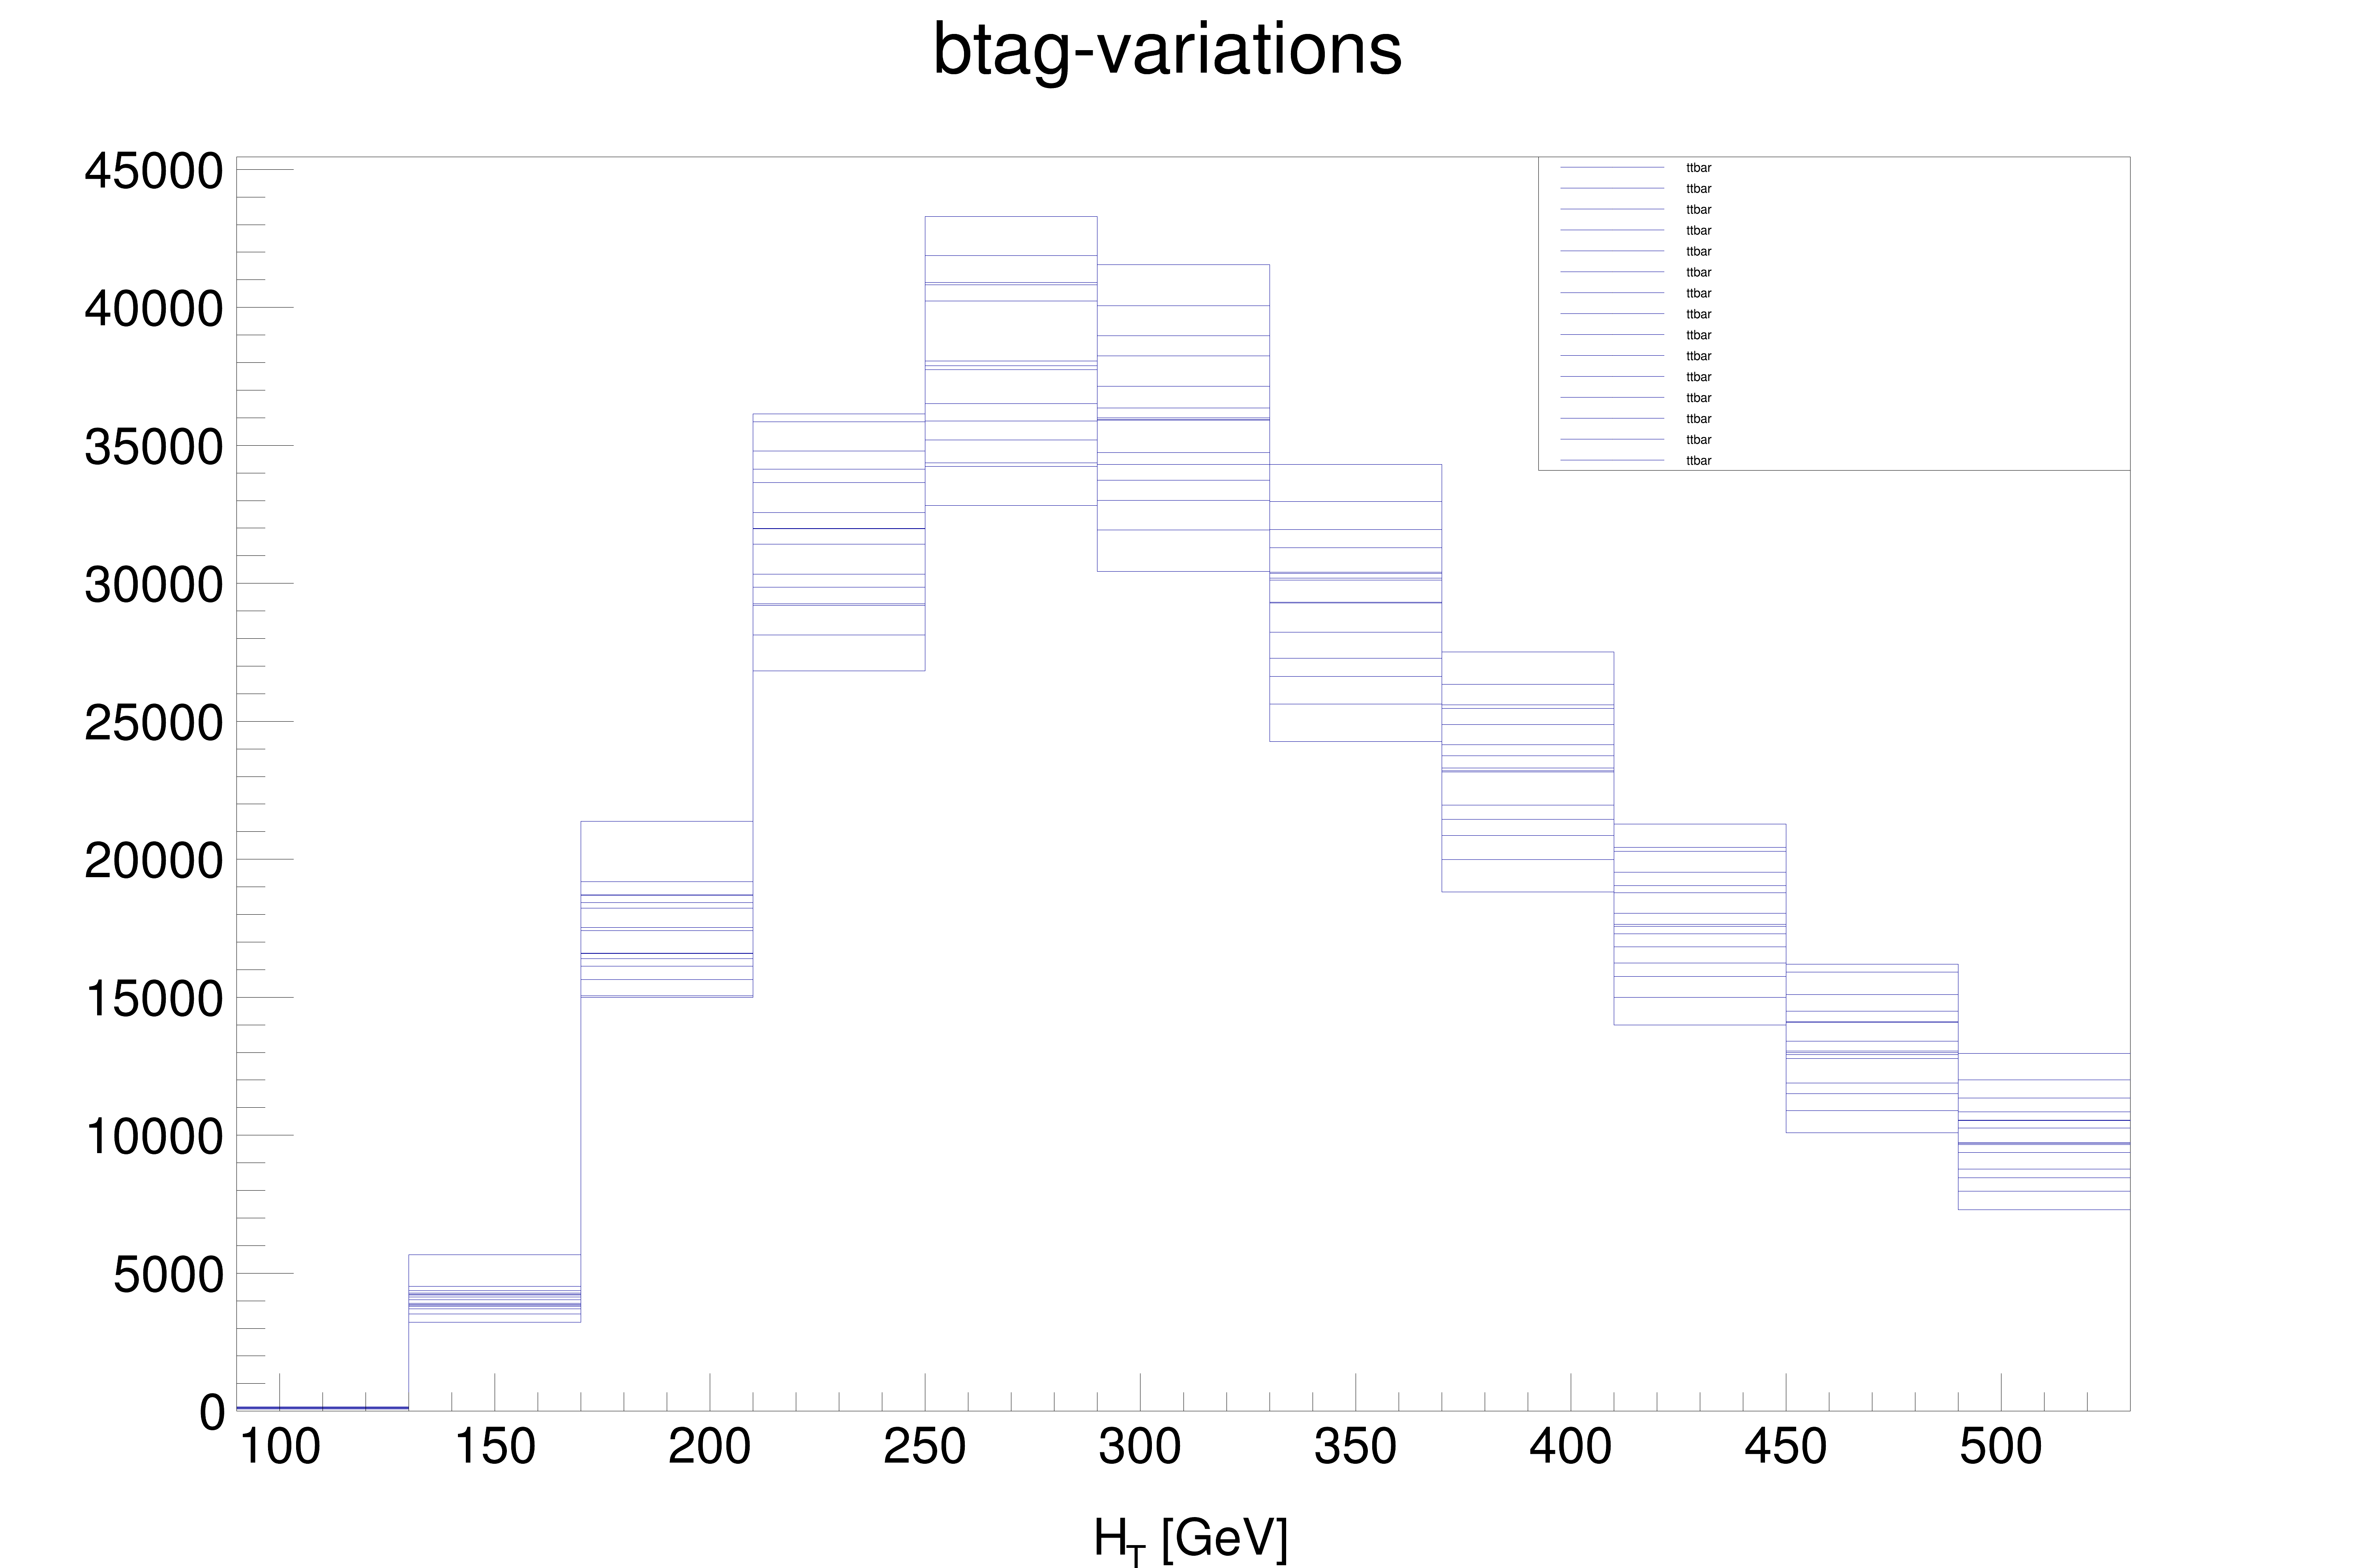

In [51]:
freshstack = analysisManager.GetVarStack(region='4j1b')
hs = THStack('j4b1btag', 'btag-variations ; H_{T} [GeV]')
for h in freshstack:
    ptr = h.Rebin(2, h.GetTitle())
    ptr.SetFillColor(0)
    ptr.SetLineWidth(1)
    hs.Add(ptr)
hs.Draw('hist nostack')
c.Draw()
x = hs.GetXaxis()
x.SetRangeUser(120, 500)
x.SetTitleOffset(1.5)
x.CenterTitle()
c.BuildLegend(0.65, 0.7, 0.9, 0.9)
c.SaveAs('btag.png')

### Save histograms to disk



In [48]:
output = ROOT.TFile.Open(FILE, 'RECREATE')
for process in analysisManager:
    for variation in analysisManager[process]:
        for region in analysisManager[process][variation]:
            hist_name = f"{region}_{process}_{variation}" if variation != 'nominal' else f"{region}_{process}"
            hist = analysisManager[process][variation][region]
            if not isinstance(hist, ROOT.TH1D): hist = hist.GetValue() #this this a bag
            if hist.IsZombie(): raise TypeError(hist_name)
            hist_sliced = ROOT.Slice(hist, 120, 550)
            hist_binned = hist_sliced.Rebin(2, hist.GetTitle())
            output.WriteObject(hist_binned, hist_name)
output.Close()

Warning in <TFile::Append>: Replacing existing TH1: h_sliced_ttbar (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_sliced_ttbar (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_sliced_ttbar (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_sliced_ttbar (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_sliced_ttbar (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_sliced_ttbar (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_sliced_ttbar (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_sliced_ttbar (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_sliced_ttbar (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_sliced_ttbar (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_sliced_ttbar (Potential me